In [1]:
# P683 - P735

### Generating Shakespearean Text Using a Character RNN 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [67]:
# get the datasets using utils.get_file() 

shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()
    
# see text

print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [70]:
# look at the char 

"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [71]:
# tokenize the text 

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

# note also have "lower=False" 

In [55]:
# text to sequence 
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [56]:
# sequence to text 
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [74]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

1115394

In [75]:
# encode all the text 
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [76]:
### how to split a sequential dataset 

# if want the split the data across time, make sure the time series is stationary

# split 90% of the text as the training set 



### Chopping into Multiple Windows 

In [77]:
# slicing, use window() 

n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [78]:
# flatten, use flat_map()

dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [80]:
# batch and shuffle the data 

np.random.seed(42)
tf.random.set_seed(42)


batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: [windows[:, :-1], windows[:, 1:]])

TypeError: in user code:

    <ipython-input-80-4007d75aa619>:9 None  *
        lambda windows: [windows[:, :-1], windows[:, 1:]]

    TypeError: '_NestedVariant' object is not subscriptable


In [64]:
# one-hot encode and prefetch 

dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

dataset = dataset.prefetch(1)

In [66]:
### Building and Training Char-RNN model 

# with GRU, dropout(also the hidden state), sparse_categorical_crossentropy, and adam optimizer 

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences = True, input_shape = [None, max_id],
                    #dropout = 0.2, recurrent_dropout = 0.2
                    ), 
    keras.layers.GRU(128, return_sequences = True, 
                    #dropout = 0.2, recurrent_dropout = 0.2
                    ), 
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam")

history = model.fit(dataset, epochs = 5)

Epoch 1/5


ValueError: Expect x to be a non-empty array or dataset.

### USing the Char-RNN Model 

In [81]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] 

### Generating Fake Shakespearean Text 

In [82]:
# use tf.random.categorical() 

def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]


In [83]:
# continuing this process 

def complete_text(text, n_chars = 50, temperature = 1): 
    for _ in range(n_chars): 
        text += next_char(text, temperature) 
    return text 


### Stateful RNN

#### previous one 

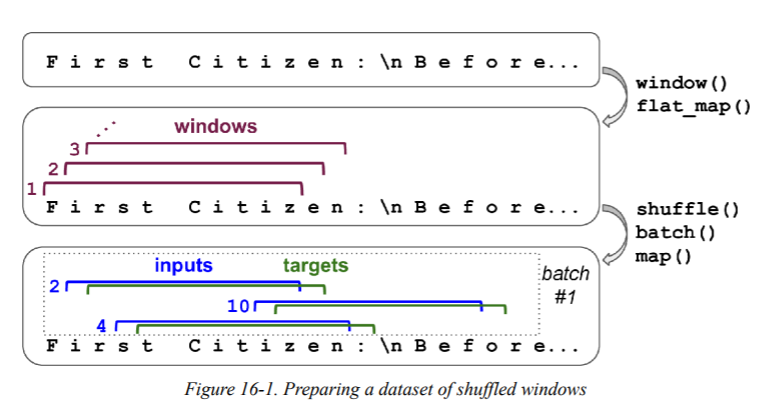

#### this one 

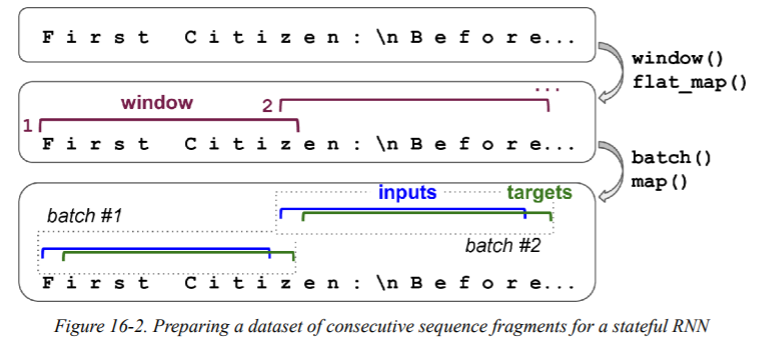

In [84]:
# use batches containing a single window 

dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [86]:
# 1,use tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
# to create consecutive batches 

# 2, set "stateful = True"

# 3, set "batch_input_shape"

model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
        dropout=0.2, recurrent_dropout=0.2,
        batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
        dropout=0.2, recurrent_dropout=0.2),
        keras.layers.TimeDistributed(keras.layers.Dense(max_id,
    activation="softmax"))
])

In [87]:
# reset the state after each epoch 

class ResetStatesCallback(keras.callbacks.Callback): 
    def on_epoch_begin(self, epoch, logs): 
        self.model.reset_states()

In [88]:
# compile and fit with more epochs

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.fit(dataset, epochs=50, callbacks=[ResetStatesCallback()])

Epoch 1/50


InvalidArgumentError:  Specified a list with shape [32,39] from a tensor with shape [1,39]
	 [[node sequential_3/gru_8/TensorArrayUnstack/TensorListFromTensor (defined at <ipython-input-88-6299c5e8c2a9>:4) ]] [Op:__inference_train_function_23394]

Function call stack:
train_function


# Sentiment Analysis 

In [3]:
# the IMDb reviews 

(X_train, y_trian), (X_test, y_test) = keras.datasets.imdb.load_data() 

In [4]:
# decode and visualize a review 

word_index = keras.datasets.imdb.get_word_index() 
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>","<unk>" )):
    id_to_word[id_] = token 
    
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [5]:
# make sure to set char_level = False

In [6]:
### Pipelining the preprocessing 

# import the data
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

# preprocess function 
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300) 
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>",b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']",b" ")
    X_batch = tf.strings.split(X_batch) 
    return X_batch.to_tensor(default_value = b"<pad>"), y_batch 

In [7]:
### build the vocabulary 

from collections import Counter 
vocabulary = Counter() 
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess): 
    for review in X_batch: 
        vocabulary.update(list(review.numpy()))

In [8]:
### keep only the most 10,000 words 

vocab_size = 10000 
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [9]:
### replace the words eith its ID 

words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

# look at a sentence 
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

In [10]:
# P700

In [11]:
# try look up a word 

In [12]:
table.lookup(tf.constant([b"This moive was faaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22, 10447,    11, 10791]], dtype=int64)>

In [13]:
### use lookup table 

def encode_words(X_batch, y_batch): 
    return table.lookup(X_batch), y_batch

### batch and map 

train_set = datasets["train"].batch(32).map(preprocess) 
train_set = train_set.map(encode_words).prefetch(1) 

In [14]:
# define the model 

embed_size = 128 
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                          input_shape = [None]),
    keras.layers.GRU(128, return_sequences = True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation = 'sigmoid')
])
model.compile(loss = "binary_crossentropy", optimizer = "adam",
             metrics = ["accuracy"])
history = model.fit(train_set, epochs = 5)

Epoch 1/5
782/782 [==============================] - 57s 69ms/step - loss: 0.6798 - accuracy: 0.5431
Epoch 2/5
782/782 [==============================] - 78s 100ms/step - loss: 0.4618 - accuracy: 0.7828
Epoch 3/5
782/782 [==============================] - 82s 105ms/step - loss: 0.3175 - accuracy: 0.8710
Epoch 4/5
782/782 [==============================] - 72s 92ms/step - loss: 0.1937 - accuracy: 0.9309
Epoch 5/5
782/782 [==============================] - 73s 93ms/step - loss: 0.1527 - accuracy: 0.9447


In [15]:
# embedding matrix: [word_ID, embedding dimension]

# embedding layer output; [batch_size, time_steps, embedding_size]

### Masking 

In [17]:
# set "mask_zero = True", then where ID = 0 would be ignored 

In [18]:
# how to build mask manually with APIs 

K = keras.backend 
inputs = keras.layers.Input(shape = [None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.Model(inputs=[inputs], outputs=[outputs])

### Reusing Pretrained Embeddings 

In [19]:
""" Simply browse the TF Hub repository, find the one you need, and
copy the code example into your project, and the module will be
automatically downloaded, along with its pretrained weights, and included
in your model. Easy!"""

' Simply browse the TF Hub repository, find the one you need, and\ncopy the code example into your project, and the module will be\nautomatically downloaded, along with its pretrained weights, and included\nin your model. Easy!'

In [23]:
!pip install tensorflow_hub
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [24]:
# need no to preprocess data 

In [25]:
# load, batch, prefetching 

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5451 - accuracy: 0.7297
Epoch 2/5
782/782 [==============================] - 7s 8ms/step - loss: 0.5132 - accuracy: 0.7490
Epoch 3/5
782/782 [==============================] - 7s 9ms/step - loss: 0.5080 - accuracy: 0.7520
Epoch 4/5
782/782 [==============================] - 7s 9ms/step - loss: 0.5044 - accuracy: 0.7550
Epoch 5/5
782/782 [==============================] - 7s 9ms/step - loss: 0.5017 - accuracy: 0.7574


### An encoder - decoder networl for neaural machine translation 

In [28]:
# for prob output 
# use "sparse_categorical_crossentropy"

# to bucketing 
# use tf.data.experimental.bucket_by_sequence_length() 

# use logit of vocab 
# have tf.nn.sampled_softmax_loss() 

!pip install tensorflow_addons

In [3]:
# define param 

tf.random.set_seed(42) 

vocab_size = 100 
embed_size = 10

In [12]:
### use Addons project 

import tensorflow_addons as tfa

# inputs
encoder_inputs = keras.layers.Input(shape = [None], dtype = np.int32) 
decoder_inputs = keras.layers.Input(shape = [None], dtype = np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype = np.int32)

# embeddings
embeddings = keras.layers.Embedding(vocab_size, embed_size) 
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs) 

# encoder 
encoder = keras.layers.LSTM(512, return_state = True) 
encoder_outputs, state_h, state_c = encoder(encoder_embeddings) 
encoder_state = [state_h, state_c]

# sampler 
sampler = tfa.seq2seq.sampler.TrainingSampler() 

### decoder 
# cell
decoder_cell = keras.layers.LSTMCell(512) 
# output layer
output_layer = keras.layers.Dense(vocab_size) 
# decoder 
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer = output_layer)

# concat 
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings, 
                                                 initial_state=encoder_state,
                                                 sequence_length=sequence_lengths)

# output prob 
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

# model 
model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
outputs=[Y_proba])



In [5]:
# compile 
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam")

In [6]:
# create data and run 
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

# history 
history = model.fit([X, X_decoder, seq_lengths], Y, epochs = 2) 

Epoch 1/2
32/32 [==============================] - 9s 142ms/step - loss: 4.6052
Epoch 2/2
32/32 [==============================] - 5s 141ms/step - loss: 4.6037


### Bidirectional RNNs 

In [8]:
# especially for machine translation 

# use "keras.layers.Bidirectional"

keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences = True))

### Beam Search 

In [9]:
 """One of the most common solutions is
beam search: it keeps track of a short list of the k most promising sentences
(say, the top three), and at each decoder step it tries to extend them by one
word, keeping only the k most likely sentences. The parameter k is called
the beam width.
"""

'One of the most common solutions is\nbeam search: it keeps track of a short list of the k most promising sentences\n(say, the top three), and at each decoder step it tries to extend them by one\nword, keeping only the k most likely sentences. The parameter k is called\nthe beam width.\n'

In [11]:
beam_width = 10 

# warps all decoder
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell= decoder_cell, 
    beam_width = beam_width, 
    output_layer = output_layer)

# copy encoder's last state 
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state, multiplier = beam_width) 

# pass to the decoder 
outputs, _, _ = decoder(
    embedding_decoder, start_tokens=start_tokens, end_token=end_token,
    initial_state=decoder_initial_state)


NameError: name 'embedding_decoder' is not defined

### Attention Mechanisms 

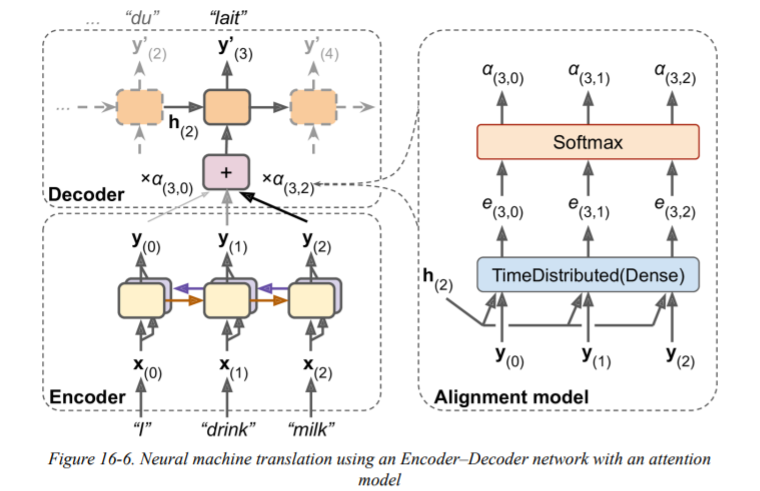

#### aligenment model 

In [16]:
### Luong dot product attention 

attention_mechanism = tfa.seq2seq.attention_wrapper.LuongAttention(
    units, 
    encoder_state,
    memory_sequence_length = encoder_sequence_length)

attention_decoder_cell = tfa.seq2seq.attention_warpper.AttentionWarpper( 
    decoder_cell,
    attention_mechanism,
    attention_layer_size = n_units)

NameError: name 'encoder_sequence_length' is not defined

### Visual Attention

### Transformer Architecture 

#### Position embeddings 

#### sin and cos functions with diff freq 

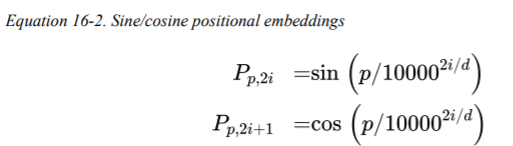

In [17]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [18]:
### P726

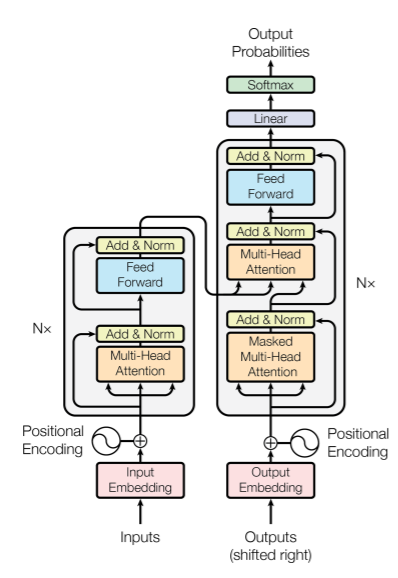

#### Multi-head attention 

In [1]:
###  the rest of the transformer model 

# use_scale would downsacler the similarity scores

Z = encoder_in 
for N in range(6): 
    Z = keras.layers.Attention(use_scale = True)([Z, Z])
    
encoder_outputs = Z 
Z = decoder_in 

for N in range(6): 
    Z = keras.layers.Attention(use_scale = True, causal = True)([Z, Z])
    Z = keras.layers.Attention(use_scale = True)([Z, encoder_outputs])
    
outputs = keras.layer.TimeDistributed(
    keras.layers.Dense(vocab_size, activation = "softmax"))(Z)

NameError: name 'encoder_in' is not defined

In [ ]:
### MultiHeadAttention

K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [ ]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape